In [69]:
library(tidyverse)
library(GGally)
library(gridExtra)

Loading in the data (replacing all "?" with NA since the predetermined NA value was "?", and NA is easier to deal with)

In [11]:
# Setting names of columns
names <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num", show_col_types = FALSE)

# Reading all of the data from https://archive.ics.uci.edu/ml/datasets/heart+Disease
cleveland_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", col_names = names, na = "?", show_col_types = FALSE)
switzerland_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data", col_names = names, na = "?", show_col_types = FALSE)
hungary_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data", col_names = names, na = "?", show_col_types = FALSE)
va_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.va.data", col_names = names, na = "?", show_col_types = FALSE)

Counts of NA values in each dataset, and within every column. This allows us to see which columns we should remove early on, and which would likely cause issues in terms of missing data.

In [14]:
NA_counts <- as.data.frame(cleveland_data[FALSE, ])
x <- substitute(list(cleveland_data, switzerland_data, hungary_data, va_data))

for (i in as.list(x)[-1]) {
    NA_counts[nrow(NA_counts) + 1,] <- map_df(get(i), ~sum(is.na(.x)))
    rownames(NA_counts)[nrow(NA_counts)] <- deparse(i)
}
NA_counts

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
cleveland_data,0,0,0,0,0,0,0,0,0,0,0,4,2,0
switzerland_data,0,0,0,2,0,75,1,1,1,6,17,118,52,0
hungary_data,0,0,0,1,23,8,1,1,1,0,190,291,266,0
va_data,0,0,0,56,7,7,0,53,53,56,102,198,166,0


It looks like the columns `slope`, `ca`, and `thal` all have a large quantity of NA values within three of the four datasets that we are using. For this reason, we chose to drop these three columns since performing imputation with such a small quantity of usable data is quite inaccurate, and also because if we choose to omit NA values then that will delete the row entirely. Additionally, we are choosing to drop `fbs`, `exang`, and `oldpeak` for a similar reason; if we choose to omit all NA values within each row, then keeping these columns will cause us to lose ~150 rows of data (since all rows with NA will be deleted). As such, removing these columns will allow us to keep more observations for our analysis, as well as simplify our model later on by exchanging less features for more data.

In [16]:
data_tidy_multi <- rbind(cleveland_data, switzerland_data, hungary_data, va_data) %>%
    select(-slope, -ca, -thal, -fbs, -exang, -oldpeak) %>%
    na.omit()

num_counts_multi <- data_tidy_multi %>%
    group_by(num) %>%
    summarize(counts = n(), proportions = counts/nrow(data_tidy_multi))
num_counts_multi

num,counts,proportions
<dbl>,<int>,<dbl>
0,373,0.44831731
1,244,0.29326923
2,100,0.12019231
3,91,0.10937500
4,24,0.02884615


We can see that there is quite a large class imbalance within the dataset, particularly in the cases of more severe heart disease. Since this analysis is mainly focused on finding the impacts of a patient on whether they do or do not have heart disease, we are largely not interested in the severity of their condition, but instead on whether or not heart disease is present at all. Therefore, we can binarize the output variable by grouping categories 1-4 into a single case (has heart disease).

In [53]:
data_tidy <- data_tidy_multi %>%
    mutate(num = ifelse(num == 0, 0, 1)) %>%
    mutate(num = as_factor(num), cp = as_factor(cp), sex = as_factor(sex), restecg = as_factor(restecg))

num_counts <- data_tidy %>%
    group_by(num) %>%
    summarize(counts = n(), proportions = counts/nrow(data_tidy))

num_counts
head(data_tidy)

num,counts,proportions
<fct>,<int>,<dbl>
0,373,0.4483173
1,459,0.5516827


age,sex,cp,trestbps,chol,restecg,thalach,num
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<fct>
63,1,1,145,233,2,150,0
67,1,4,160,286,2,108,1
67,1,4,120,229,2,129,1
37,1,3,130,250,0,187,0
41,0,2,130,204,2,172,0
56,1,2,120,236,0,178,0


Evidently, the data is now much more balanced. Now that we have fully tidied our data (`data_tidy`), we can begin the variable selection portion of the analysis. First, we can make a covariance matrix between all continuous variables in order to get a preliminary look at whether or not there exist any inter-dependencies between variables (ie. colinearity). 

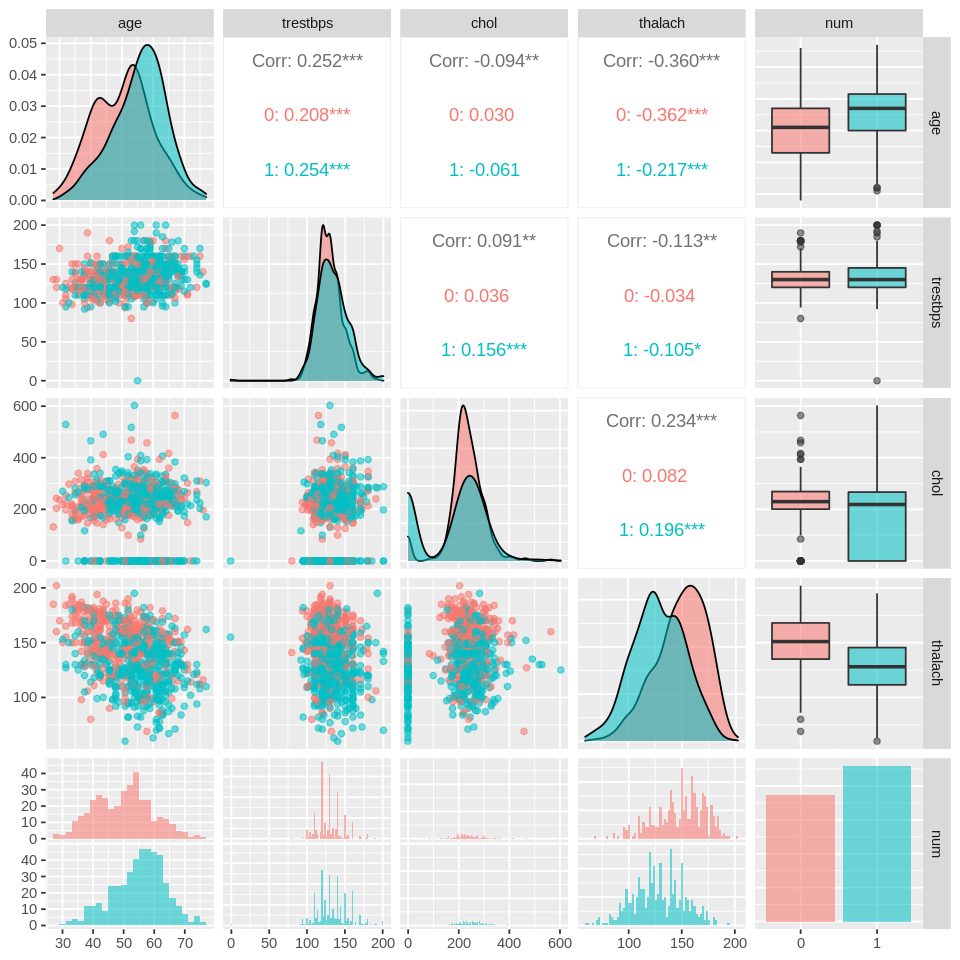

In [66]:
options(repr.plot.width = 8, repr.plot.height = 8)

covariance_plot <- data_tidy %>%
    select(age, trestbps, chol, thalach, num) %>%
    # filter(chol != 0) %>%
    ggpairs(aes(colour = num, alpha = 0.5), lower = list(combo = wrap("facethist", binwidth = 2)))

covariance_plot

**Talk about what can be seen from above, and why we need to do something similar with the categorical variables in the form of boxplots.**

In [75]:
# Helper function to store the legend of the plot
get_legend<-function(myggplot){
  tmp <- ggplot_gtable(ggplot_build(myggplot))
  leg <- which(sapply(tmp$grobs, function(x) x$name) == "guide-box")
  legend <- tmp$grobs[[leg]]
  return(legend)
}

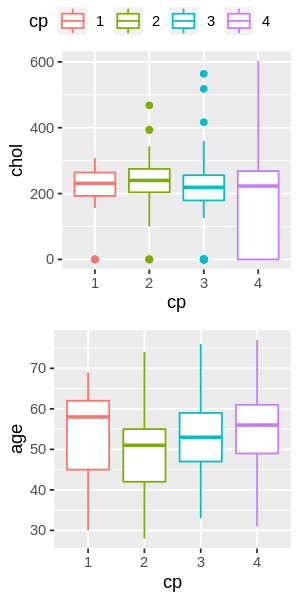

In [129]:
options(repr.plot.width = 2.5, repr.plot.height = 5)

plot1 <- data_tidy %>%
    ggplot(aes(x = cp, y = chol, colour = cp)) +
    geom_boxplot() + 
    theme(legend.position = "top")
    
legend <- get_legend(plot1)

plot1 <- plot1 + theme(legend.position="none")

plot2 <- data_tidy %>%
    ggplot(aes(x = cp, y = age, colour = cp)) +
    geom_boxplot() + 
    theme(legend.position="none")
              
grid.arrange(legend, plot1, plot2, ncol = 1, widths = c(2.7), heights = c(1.5, 10, 10))

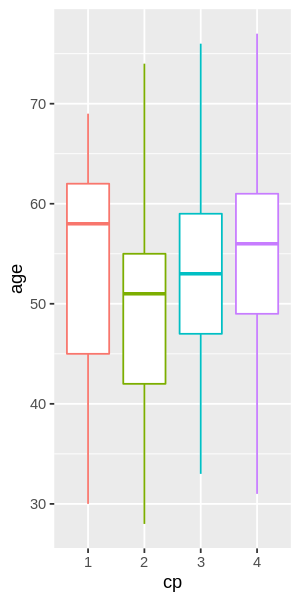

In [147]:
numeric_variables <- colnames(select(data_tidy, where(is.numeric)))
count <- 1
plot1 <- data_tidy %>% ggplot()
plot2 <- data_tidy %>% ggplot()
plot3 <- data_tidy %>% ggplot()
plot4 <- data_tidy %>% ggplot()

for (i in numeric_variables) {
    if (count == 1) {
        
        plot1 <- plot1 + geom_boxplot(aes(x = cp, y = .data[[i]], colour = cp)) + 
            theme(legend.position = "top")
        
        legend <- get_legend(plot1)
        
        plot1 <- plot1 + theme(legend.position="none")
        
        count <- count + 1
    }
    
    
    
}

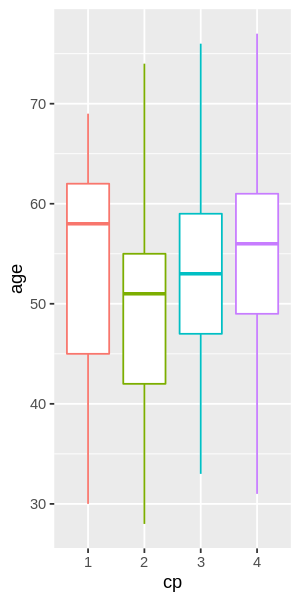

In [158]:
assign(, eval(parse(text = paste0("plot", toString(1))))


In [163]:
str <- parse(text = paste0("plot", toString(1)))

ERROR: Error in str == "plot1": comparison is not allowed for expressions


In [143]:
numeric_variables

[1] "age"      "trestbps" "chol"     "thalach"

The first thing that is worth noting is that in all plots with `chol`, we have a very large amount of observations with `chol` equal to 0. Naturally, our tidy data will be prone to outliers as no form of data collection is fully robust, however, upon further inspection of the graphs above, we can see that there are so many values of `chol` equal to 0 that the quartiles of the boxplots get skewed. **insert scientific logic here on why chol = 0 is unrealistic**. 

Therefore, since this measurment is likely a mistake in the data collection process, and since it is skewing the distribution (including with the mean and standard deviation) of the variable, we have no choice but to remove all rows with `chol` being 0.

- Add new columns that denotes which country the data is from
- Use correlation matrix to plot relationship between numerical variables (drop categorical variables from matrix)
- Use boxplots for all categorical variables against all numerical variables (ie. 5 columns and n rows for numerical variables)
- Worth looking into chol = 0, since there are 158 observations with no cholesterol (which is suspicious)
- Add summary table